In [1]:
# Let's run an example where we observe with ComCam

In [2]:
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import BaseSurvey
from rubin_scheduler.scheduler.utils import SkyAreaGenerator, Footprint, make_rolling_footprints
from rubin_scheduler.scheduler.schedulers import CoreScheduler, SimpleBandSched
from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.detailers import BaseDetailer
from rubin_scheduler.utils import _approx_ra_dec2_alt_az, _approx_altaz2pa
import rubin_scheduler.scheduler.basis_functions as bf


from rubin_scheduler.scheduler.surveys import BlobSurvey, GreedySurvey
from rubin_scheduler.scheduler import sim_runner

from rubin_scheduler.site_models import Almanac


import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd

In [3]:
# load up a model observatory.
nside=512  # Specify the HEALpix resolution we want to do everything in. Need to turn up for comcam
mjd_start = 60218.
mo = ModelObservatory(nside=nside, mjd_start=mjd_start)

almanac = Almanac(mjd_start=mjd_start)
sun_moon_info = almanac.get_sun_moon_positions(mjd_start)
sun_ra_start = sun_moon_info["sun_RA"].copy()

conditions = mo.return_conditions()


In [4]:
# Let's start out with a simple 2-band footprint where we want 1 observations in r for every 2 observations in g
blank_map = np.zeros(hp.nside2npix(nside)) + np.nan
# cut down to a very narrow band
indx = np.where((conditions.dec < np.radians(-15)) & (conditions.dec > np.radians(-20)))
simple_fp = {'r': blank_map + 0, 'g': blank_map + 0}
simple_fp['r'][indx] = 1
simple_fp['g'][indx] = 1

fp = Footprint(mjd_start, sun_ra_start, nside=nside)
for bandname in simple_fp:
    fp.set_footprint(bandname, simple_fp[bandname])

In [5]:
# Let's make two survey objects, one that will observe blobs in r, one in g

# set nside everywhere, and camera="comcam" to both surveys and scheduler!
# Need to set grow_blob to false to avoid a giant loop

footprint_weight = 1.
m5_weight = 0.5

# Specify no detailers so there's no unwanted rotational dithers.
detailers = []

red_fp_basis = bf.FootprintBasisFunction(bandname='r', footprint=fp, nside=nside)
m5_basis_r = bf.M5DiffBasisFunction(bandname='r', nside=nside)
red_survey = BlobSurvey([red_fp_basis, m5_basis_r],
                        [footprint_weight, m5_weight],
                        bandname1='r', survey_name='r_blob', nside=nside,
                        camera="comcam", grow_blob=False, detailers=detailers, 
                        dither=False, twilight_scale=False)

blue_fp_basis = bf.FootprintBasisFunction(bandname='g', footprint=fp, nside=nside)
m5_basis_g = bf.M5DiffBasisFunction(bandname='g', nside=nside)
blue_survey = BlobSurvey([blue_fp_basis, m5_basis_g],
                         [footprint_weight, m5_weight],
                         bandname1='g', survey_name='g_blob', nside=nside,
                         camera="comcam", grow_blob=False, detailers=detailers, dither=False, twilight_scale=False)

scheduler = CoreScheduler([red_survey, blue_survey], nside=nside, camera="comcam")


In [6]:
mo = ModelObservatory(nside=nside, mjd_start=mjd_start)

# run it for a week
mo, scheduler, observations = sim_runner(mo, scheduler, sim_duration=3, verbose=True)

progress = 78.55%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 99.49%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 2214 observations
ran in 1 min = 0.0 hours


In [7]:
conditions = mo.return_conditions()
fp_bf = scheduler.survey_lists[0][0].basis_functions[0]

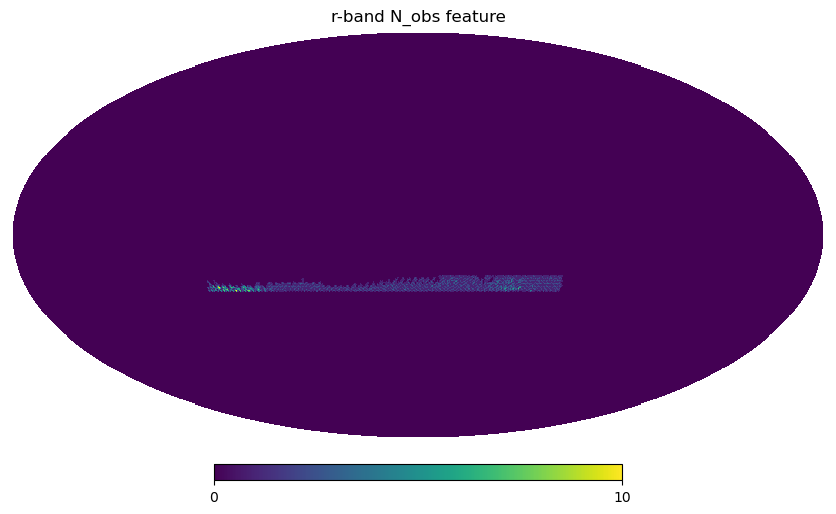

In [8]:
# The basis function holds a dict of Feature objects that track the progress of the survey
hp.mollview(fp_bf.survey_features['N_obs'](), title='r-band N_obs feature')


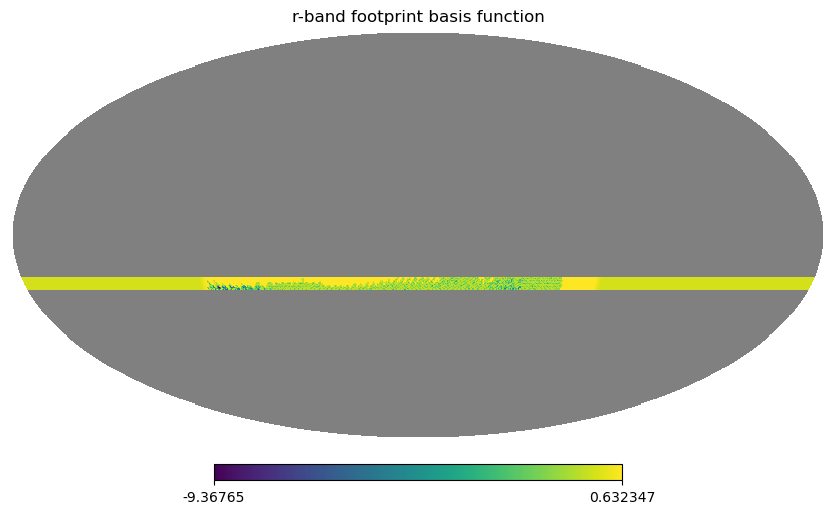

In [9]:
hp.mollview(fp_bf(conditions), title='r-band footprint basis function')

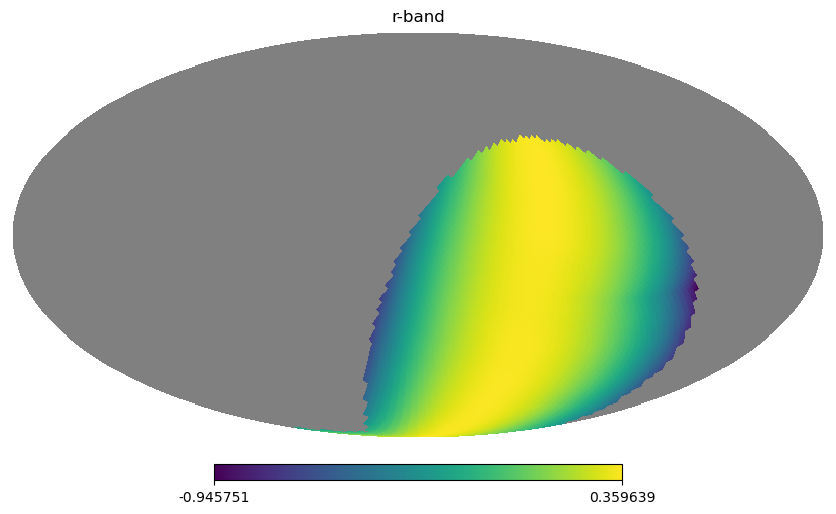

In [10]:
hp.mollview(scheduler.survey_lists[0][0].basis_functions[1](conditions), title='r-band')

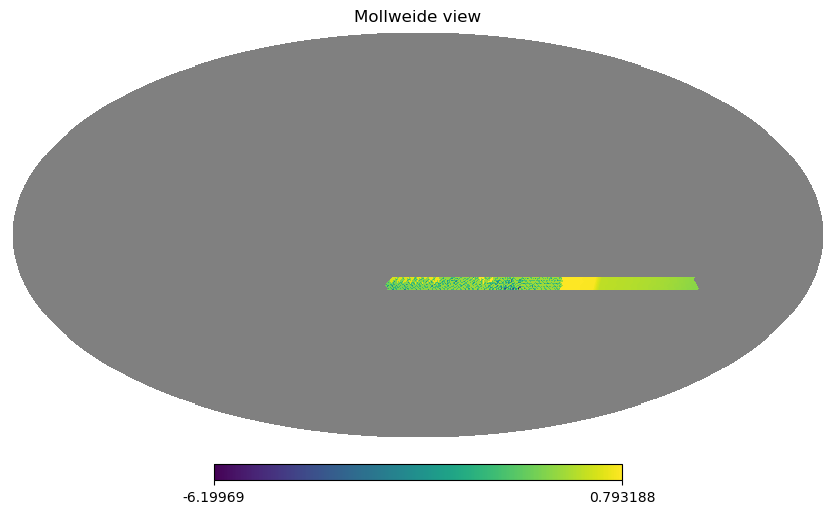

In [11]:
conditions = mo.return_conditions()
rw = scheduler.survey_lists[0][0].calc_reward_function(conditions)
hp.mollview(rw)

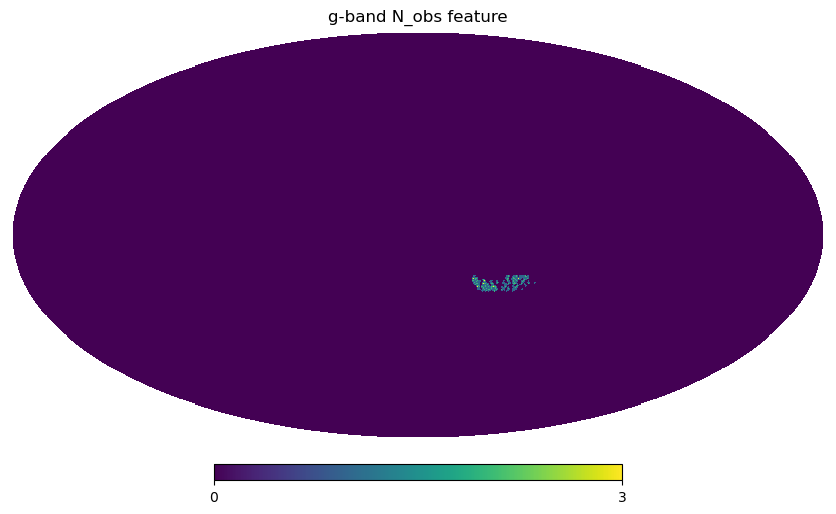

In [12]:
# And now in the g-band
hp.mollview(scheduler.survey_lists[0][1].basis_functions[0].survey_features['N_obs'](),
            title='g-band N_obs feature')

In [13]:
conditions

Conditions at 0x374251790
============================
nside:  512   
site:  LSST   
exptime:  30.0   
lmst:  [20.15383354]   
clouds:  None   
current_band:  g   
mounted_bands:  ['g', 'r', 'i', 'z', 'y']   
night:  3   
wind_speed:  None   
wind_direction:  None   
len(scheduled_observations):  0   
len(queue):  None   
moonPhase:  66.25041932505319   
bulk_cloud:  [0.125]   
targets_of_opportunity:  None   
cumulative_azimuth_rad:  [0.73583428]   

Positions (radians)
-------------------
| name      |        alt |        az |       RA |       decl |   rot |
|:----------|-----------:|----------:|---------:|-----------:|------:|
| sun       |  -0.299606 |   4.44103 | 3.30496  | -0.0703776 |   nan |
| moon      |  -0.754652 |   1.42281 | 1.19855  |  0.452355  |   nan |
| venus     | nan        | nan       | 0.708795 |  0.239783  |   nan |
| mars      | nan        | nan       | 3.67937  | -0.208655  |   nan |
| jupiter   | nan        | nan       | 0.619617 |  0.225214  |   nan |
| saturn    | nan        | nan       | 5.8841   | -0.197575  |   nan |
| telescope |   1.32839  |   0.36459 | 5.35471  | -0.299691  |     0 |

Positions (degrees)
-------------------
| name      |      alt |       az |       RA |      decl |   rot |
|:----------|---------:|---------:|---------:|----------:|------:|
| sun       | -17.1662 | 254.452  | 189.36   |  -4.03234 |   nan |
| moon      | -43.2384 |  81.5208 |  68.6721 |  25.918   |   nan |
| venus     | nan      | nan      |  40.611  |  13.7385  |   nan |
| mars      | nan      | nan      | 210.812  | -11.955   |   nan |
| jupiter   | nan      | nan      |  35.5014 |  12.9038  |   nan |
| saturn    | nan      | nan      | 337.134  | -11.3202  |   nan |
| telescope |  76.111  |  20.8894 | 306.802  | -17.1711  |     0 |

Events
------
| event           |     MJD | date                          |
|:----------------|--------:|:------------------------------|
| sunset          | 60220.9 | 2023-10-03 22:41:37.111929953 |
| sun_n12_setting | 60221   | 2023-10-03 23:37:50.935432609 |
| mjd             | 60221   | 2023-10-04 00:02:30.047868493 |
| sun_n18_setting | 60221   | 2023-10-04 00:06:30.864506365 |
| moonrise        | 60221.2 | 2023-10-04 03:46:27.084178626 |
| sun_n18_rising  | 60221.4 | 2023-10-04 08:56:51.575312915 |
| sun_n12_rising  | 60221.4 | 2023-10-04 09:25:30.419862274 |
| sunrise         | 60221.4 | 2023-10-04 10:21:41.600530739 |
| moonset         | 60221.6 | 2023-10-04 13:42:10.994023379 |

Maps
----
| map             |   nside |       min |           max |    median |
|:----------------|--------:|----------:|--------------:|----------:|
| slewtime        |     512 |  3.51977  | 156           | 91.9337   |
| dec             |     512 | -1.5692   |   1.5692      |  0        |
| ra              |     512 |  0        |   6.28165     |  3.14083  |
| airmass         |     512 |  1        |   6.23427e+06 |  1.99994  |
| skybrightness_u |     512 | 21.6196   |  22.5496      | 22.3529   |
| skybrightness_g |     512 | 20.6725   |  22.1295      | 21.8867   |
| skybrightness_r |     512 | 19.866    |  21.2268      | 20.9643   |
| skybrightness_i |     512 | 19.185    |  20.3578      | 20.0655   |
| skybrightness_z |     512 | 18.4529   |  19.4532      | 19.1365   |
| skybrightness_y |     512 | 17.6794   |  18.5703      | 18.2457   |
| fwhm_eff_u      |     512 |  0.691128 |   2.98799     |  0.99632  |
| fwhm_eff_g      |     512 |  0.663458 |   2.86837     |  0.956431 |
| fwhm_eff_r      |     512 |  0.638528 |   2.76058     |  0.920492 |
| fwhm_eff_i      |     512 |  0.621559 |   2.68722     |  0.896031 |
| fwhm_eff_z      |     512 |  0.610413 |   2.63903     |  0.879962 |
| fwhm_eff_y      |     512 |  0.601557 |   2.60075     |  0.867196 |
| m5_depth_u      |     512 | 22.3884   |  23.8923      | 23.4308   |
| m5_depth_g      |     512 | 23.6978   |  25.1714      | 24.7894   |
| m5_depth_r      |     512 | 23.437    |  24.7861      | 24.4104   |
| m5_depth_i      |     512 | 23.0947   |  24.3412      | 23.9459   |
| m5_depth_z      |     512 | 22.6084   |  23.746       | 23.3408   |
| m5_depth_y      |     512 | 21.4833   |  22.7898      | 22.3368   |


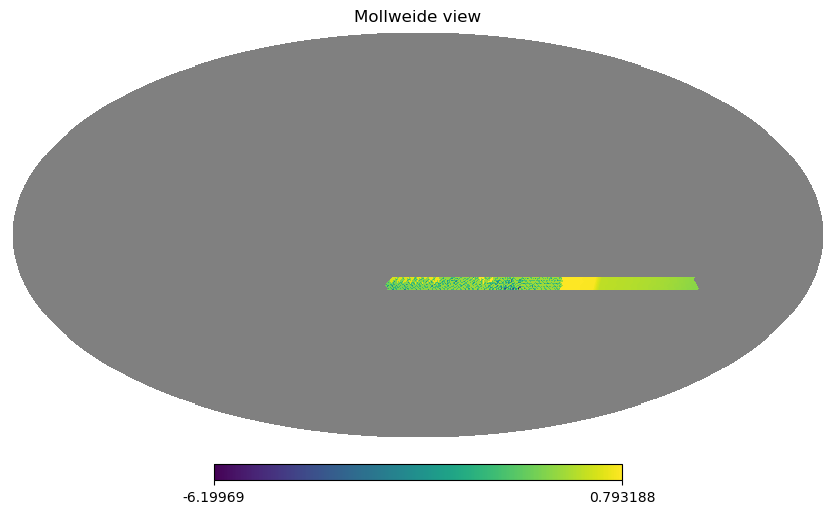

In [14]:
hp.mollview(scheduler.survey_lists[0][0].calc_reward_function(conditions))

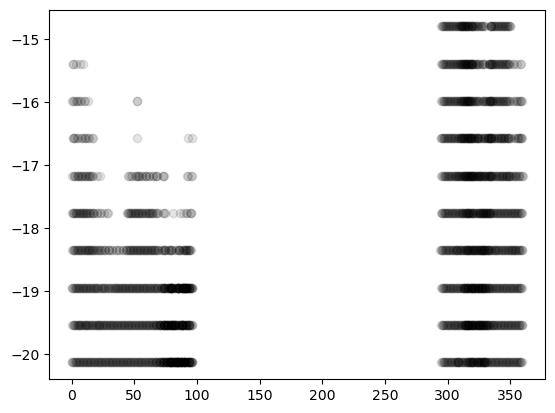

In [15]:
plt.plot(np.degrees(observations["RA"]), np.degrees(observations["dec"]), 'ko', alpha=.1)
